In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os

In [2]:
def plot_voltage_temp(dataset, title = ''):
    fig, axs = plt.subplots(4, 2, figsize=(8, 8), dpi=200)
    fig.suptitle(title)

    for i in range(1, 8):
        ax = axs[(i-1)//2, (i-1)%2]
        ax.scatter(1/dataset['T'], dataset[f'v{i}'], s=5)
        ax.set_title(f'v{i}')

    fig.supxlabel('T (1/K)')
    fig.supylabel('Voltage (V)')
    plt.tight_layout()
    plt.show() 

## Load Data

In [3]:
user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents'

In [4]:
# No magnet or magnetic field
onemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/1mA_no_magnet_3.csv', header=2)
threemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/3mA_no_magnet.csv', header=2)
tenmA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/10mA_no_magnet.csv', header=2)
thirtymA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/30mA_no_magnet.csv', header=2)

## 1. No Heating or Magnetic field

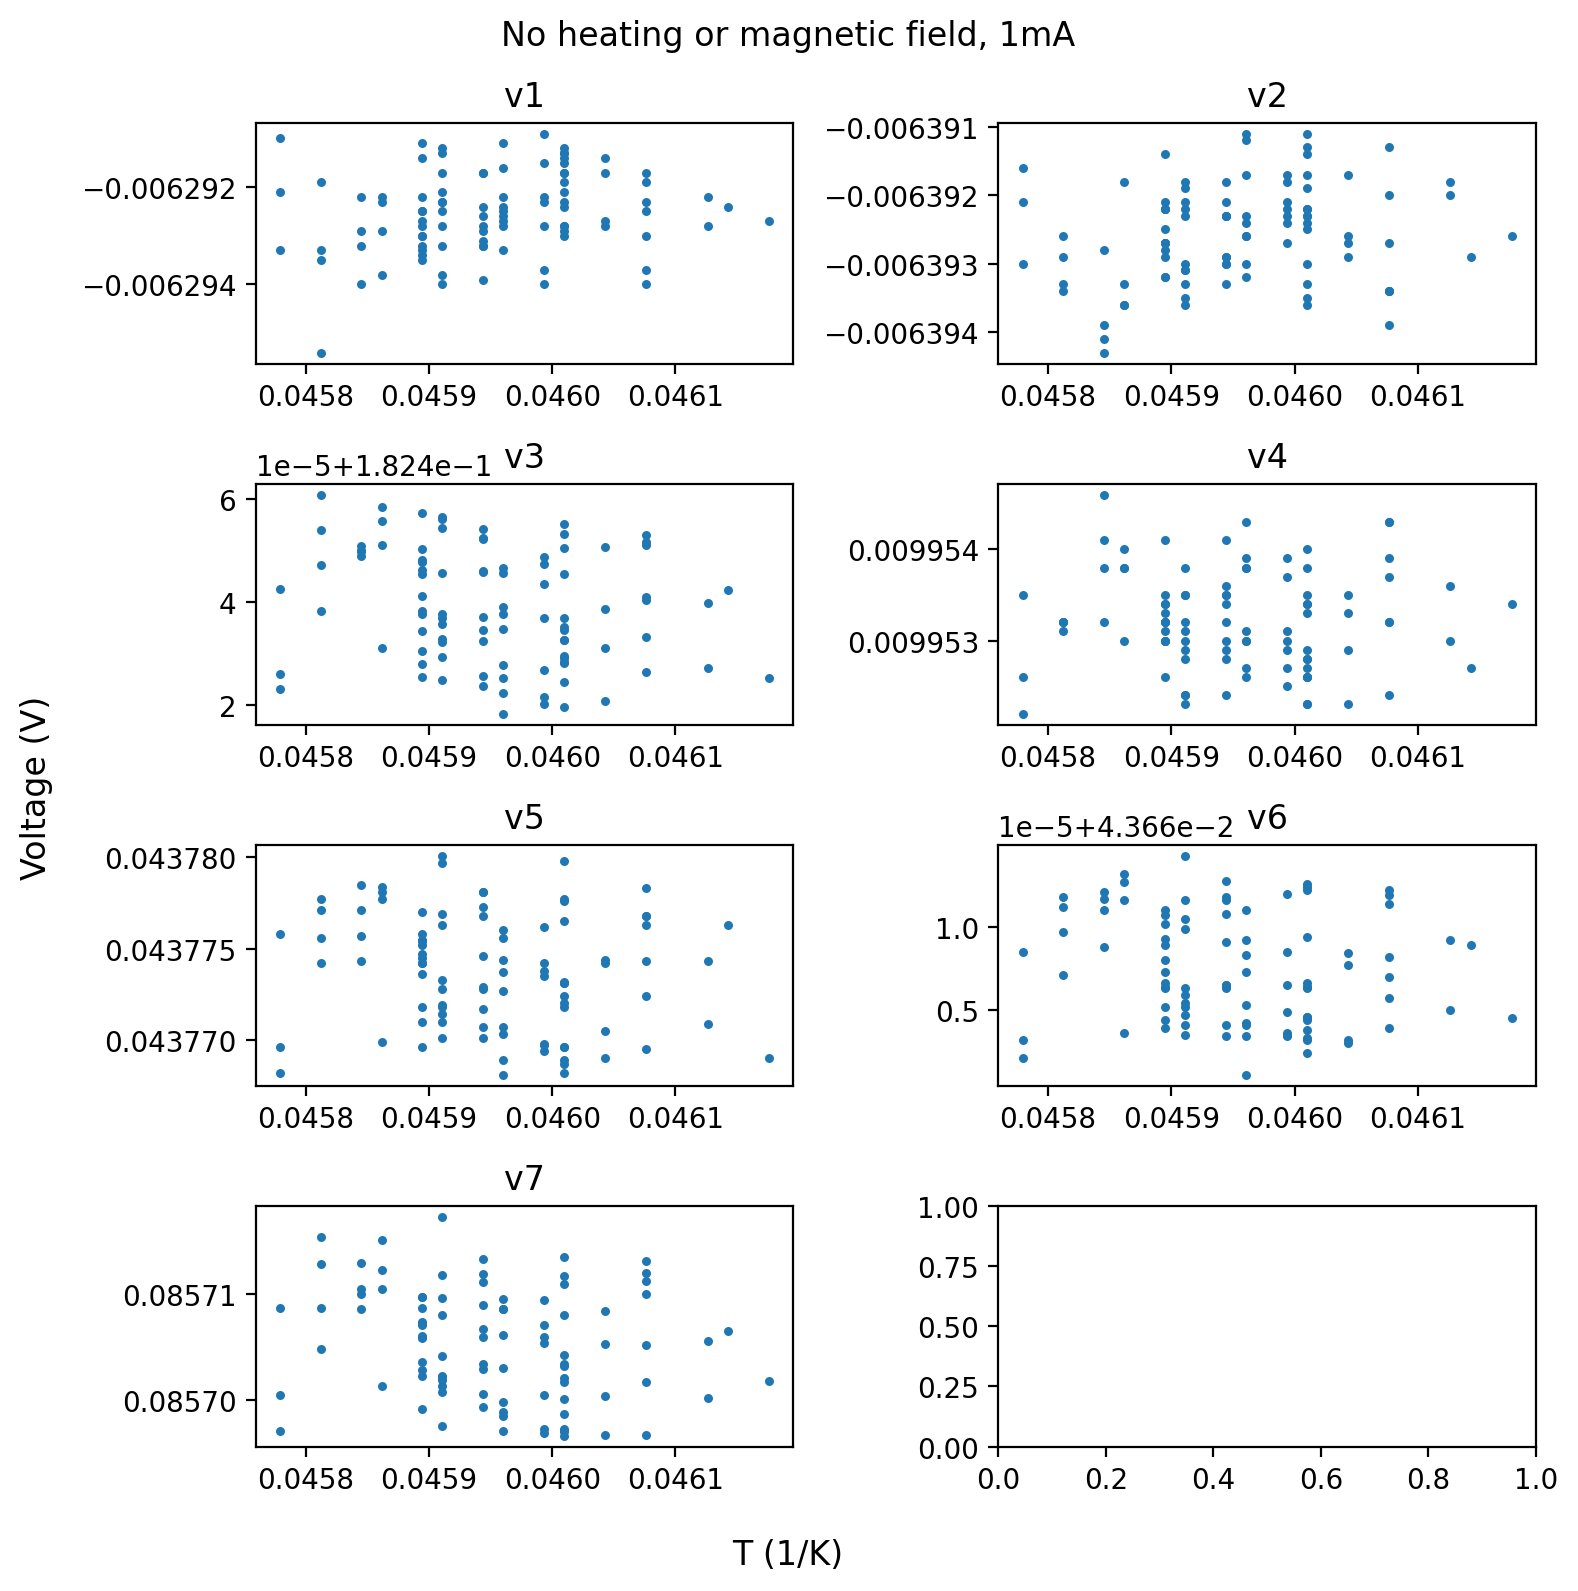

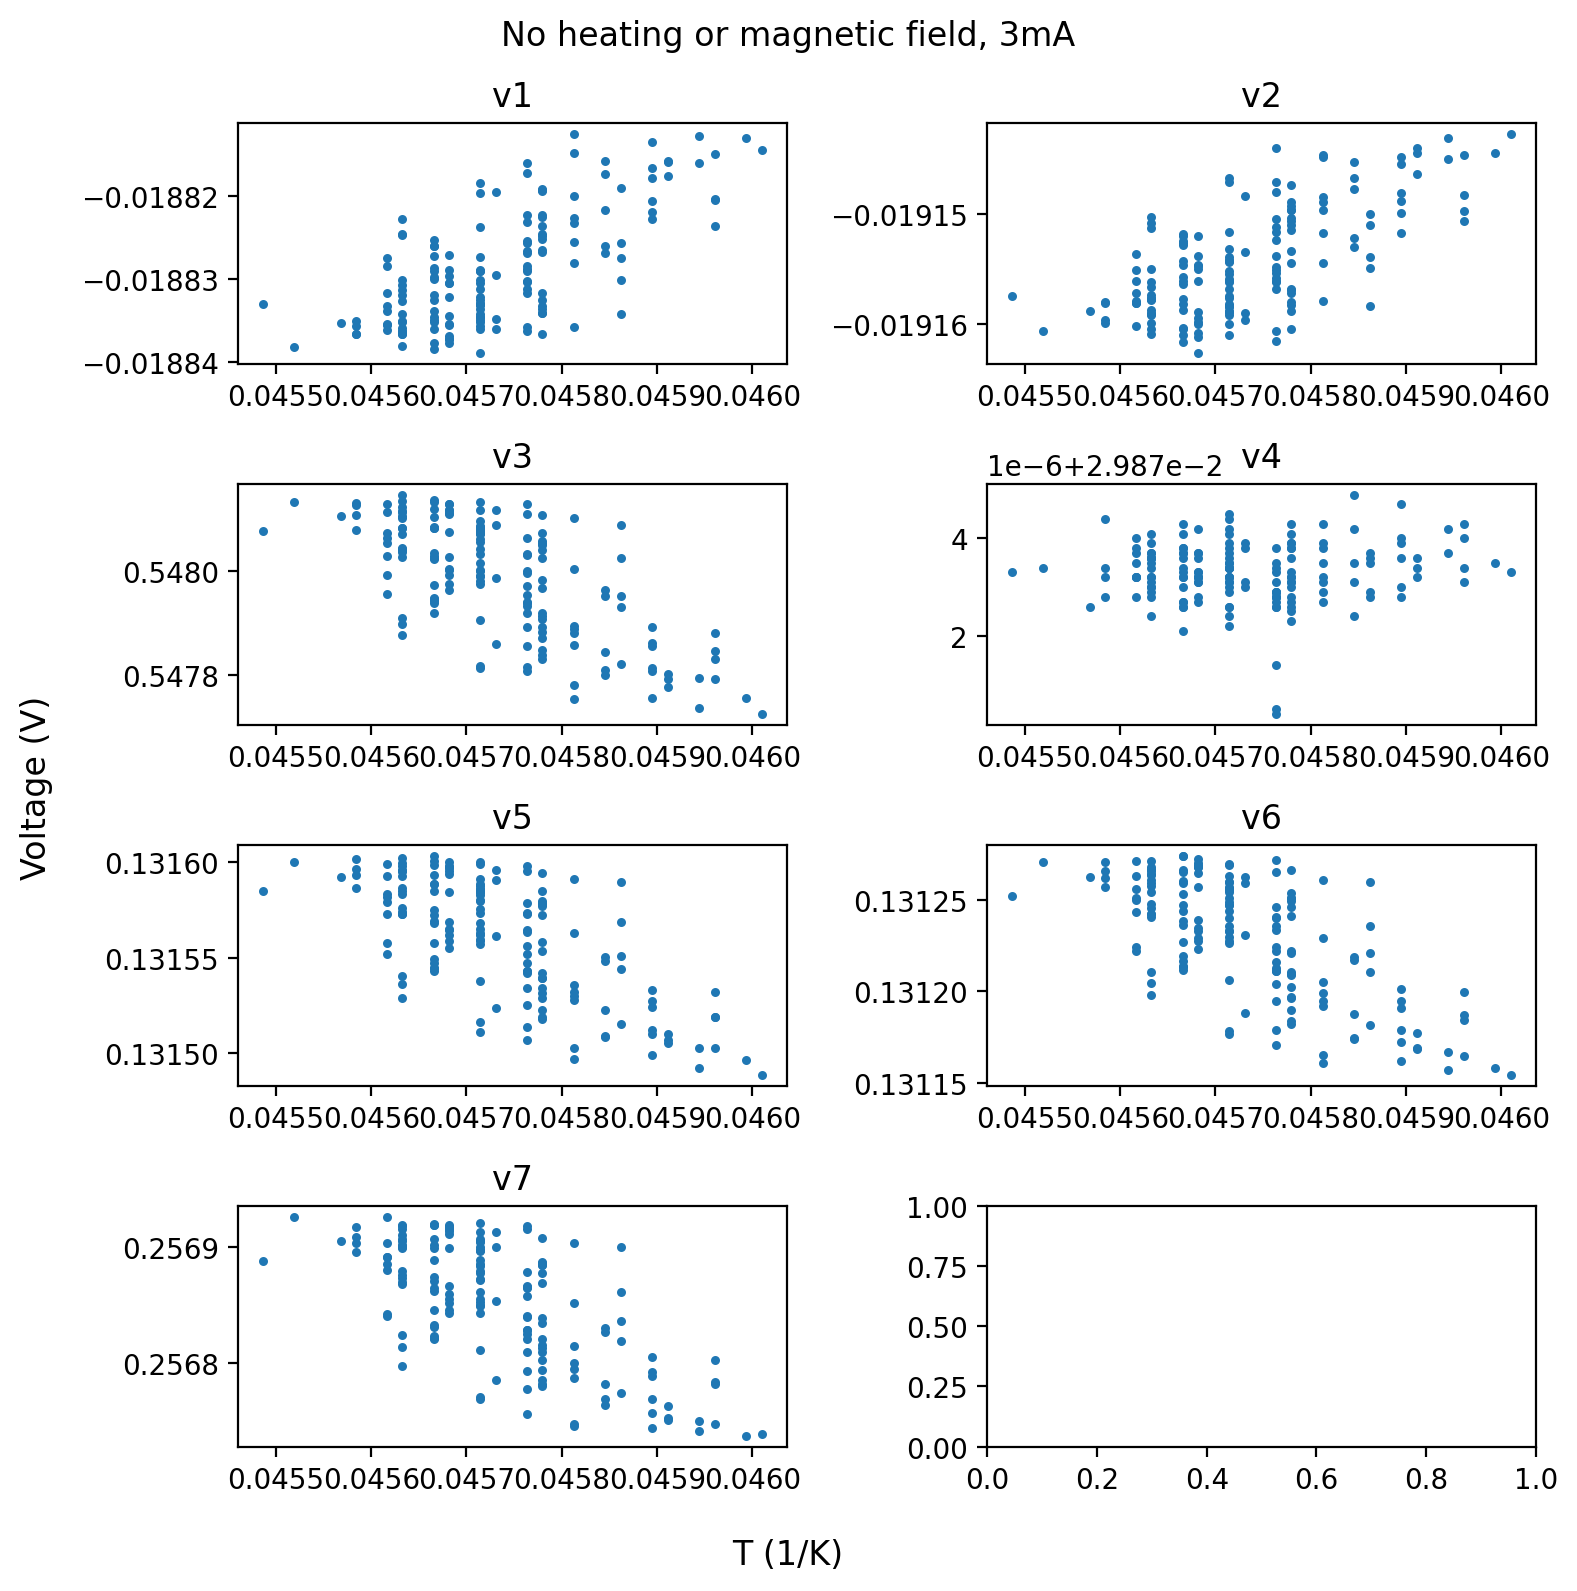

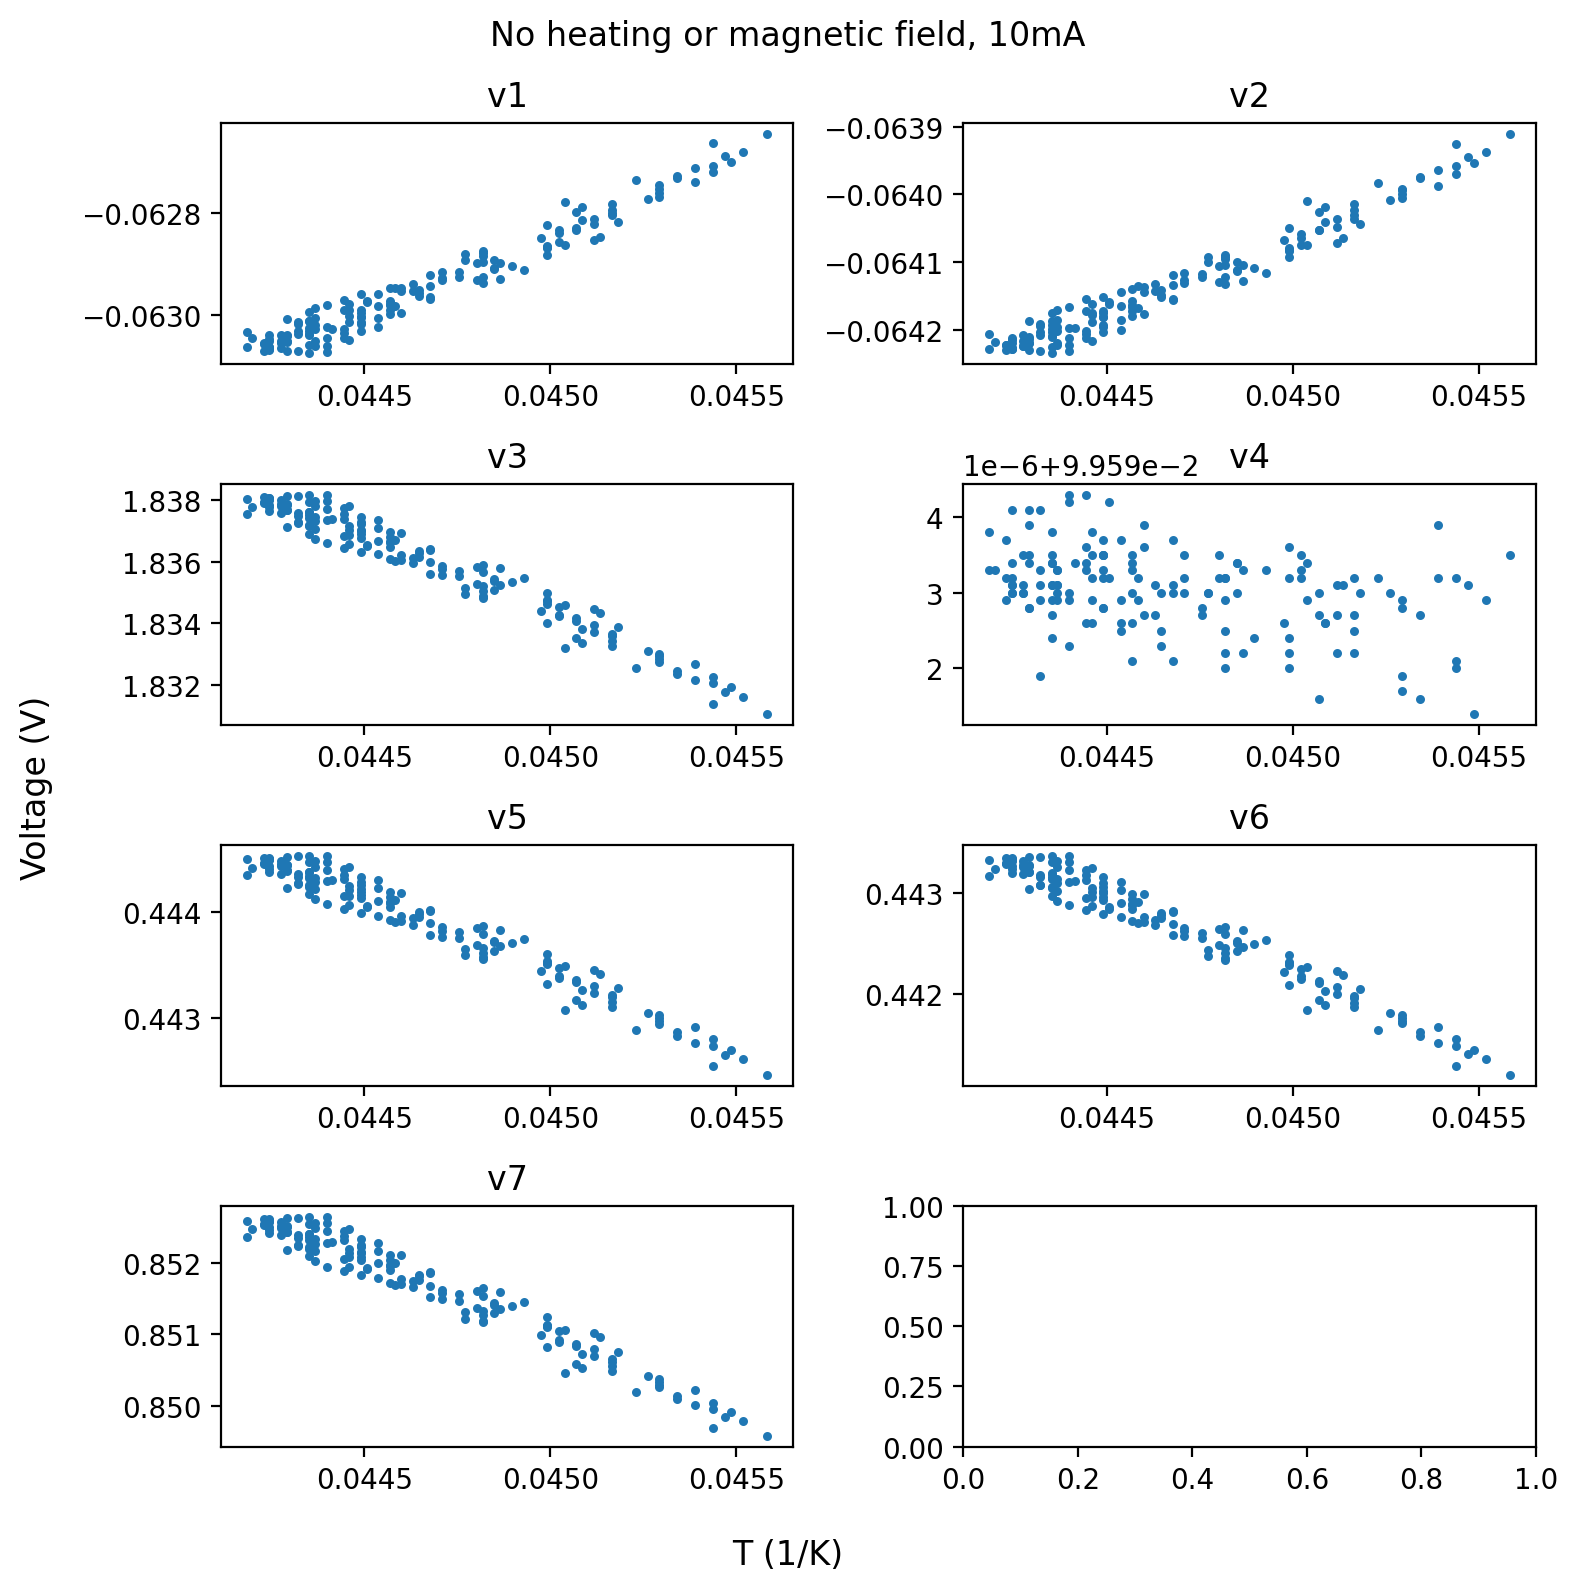

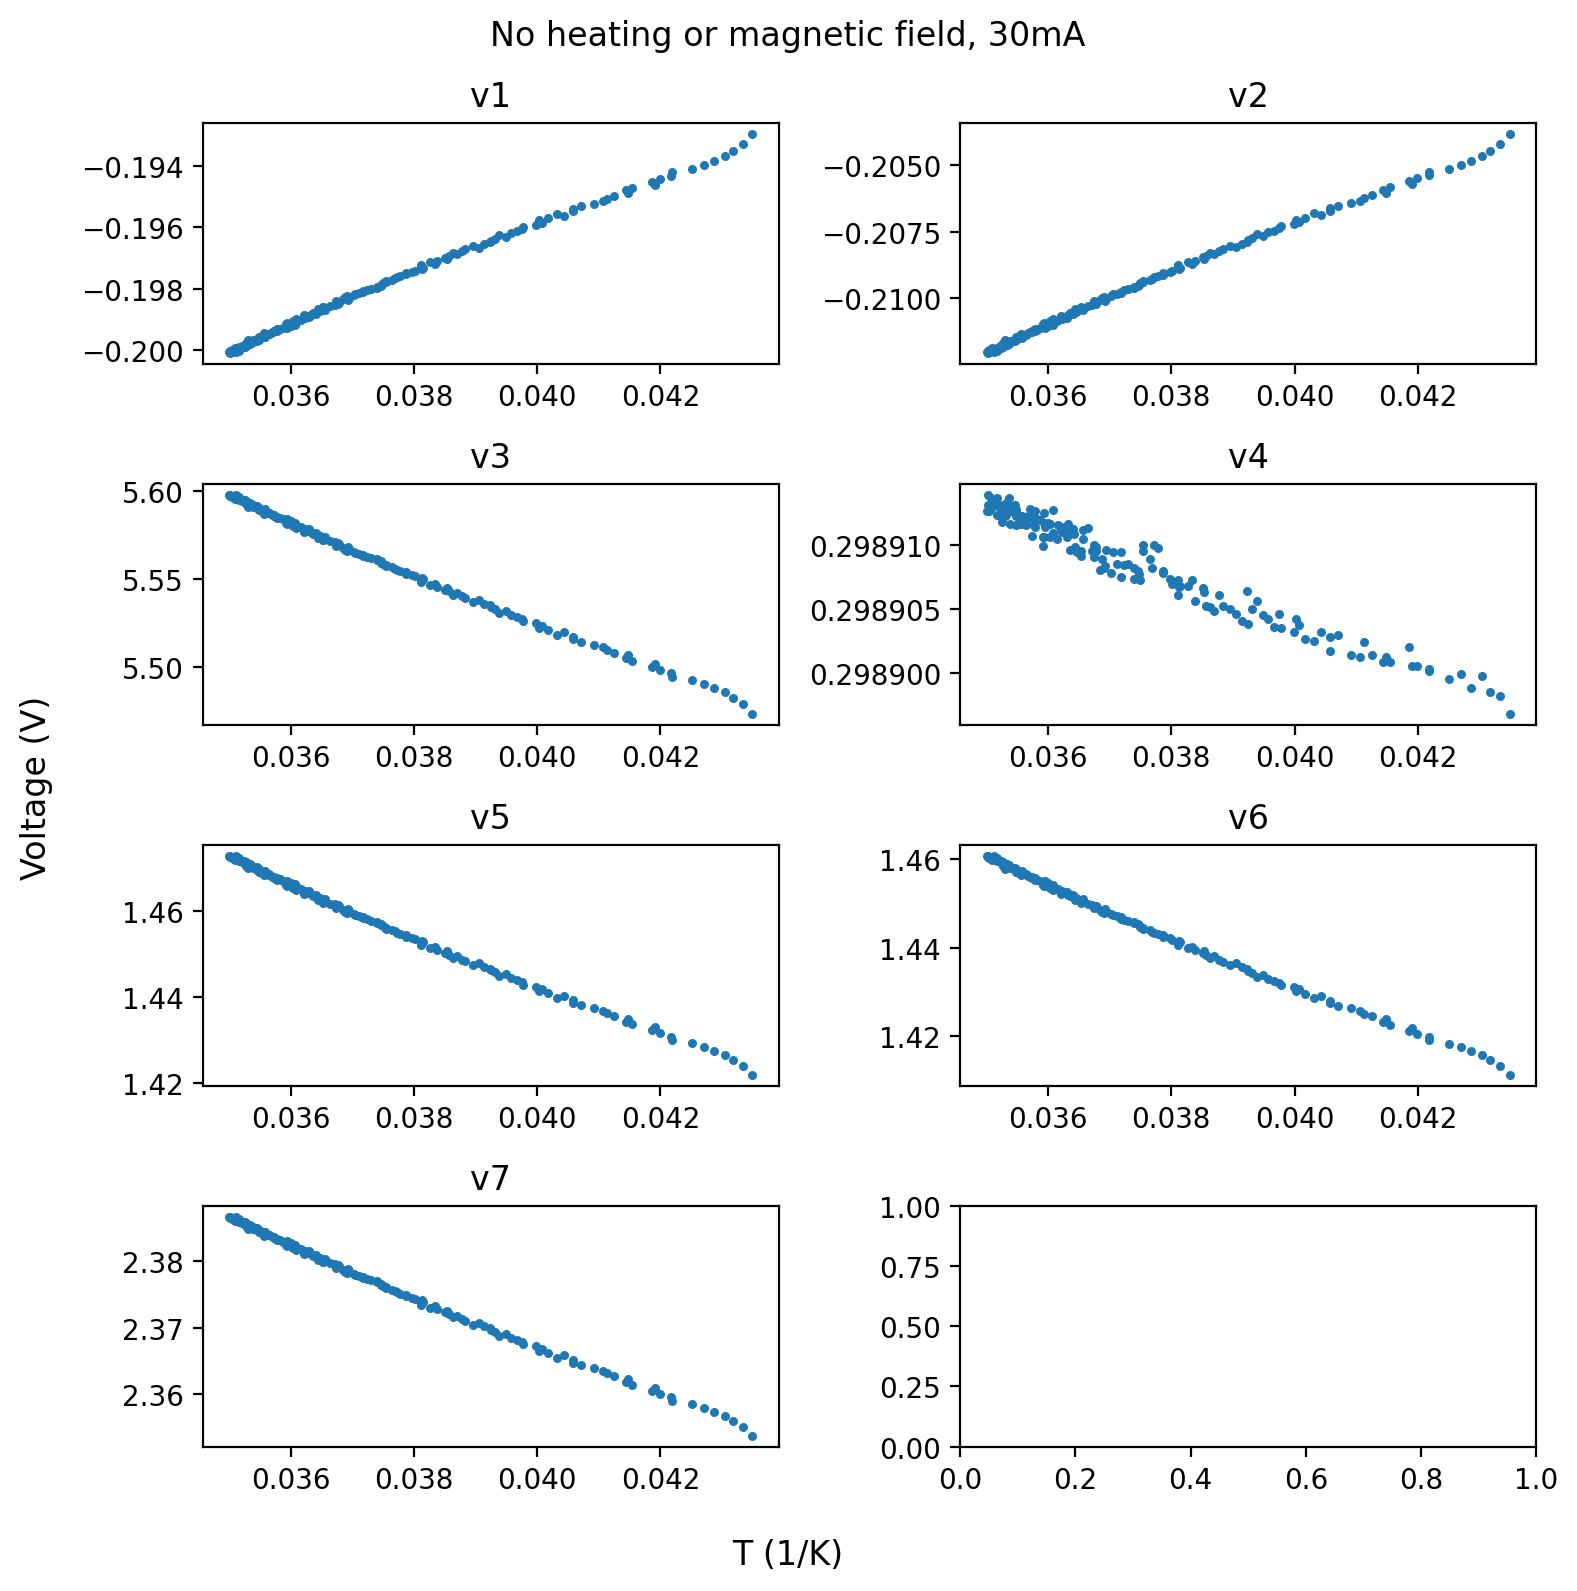

In [5]:
# load csv using pandas\n ,
onemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/1mA_no_magnet_3.csv', header=2)
plot_voltage_temp(onemA_no_magnet, 'No heating or magnetic field, 1mA')

threemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/3mA_no_magnet.csv', header=2)
plot_voltage_temp(threemA_no_magnet, 'No heating or magnetic field, 3mA')

tenmA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/10mA_no_magnet.csv', header=2)
plot_voltage_temp(tenmA_no_magnet, 'No heating or magnetic field, 10mA')

thirtymA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/30mA_no_magnet.csv', header=2)
plot_voltage_temp(thirtymA_no_magnet, 'No heating or magnetic field, 30mA') 

## Interpolation

In [6]:
def interp_data(dataset, new_path=''):
    interp_dataset = dict()
    common_time = dataset["t9"]  # using time of temperature readings

    interp_dataset['t'] = common_time

    for i in range(1, 8):
        interp_data = interp1d(dataset[f't{i}'], dataset[f'v{i}'], bounds_error=False, fill_value="extrapolate")
        interp_dataset[f'v{i}'] = interp_data(common_time)

    np.savez(f'{new_path}.npz', interp_dataset)
    return interp_dataset

## Interim Report Plots

### Raw measurement plot

In [7]:
# loading one of the heated, magnetic field datasets we took on the 12th

path = user_path+'/PHYS469/hall_experiment/09122024/300mV_10mA_heating.csv'
data = pd.read_csv(path, header=2)
dict = interp_data(data, '300mV_10mA_heating')

Text(0, 0.5, '1/v1 (1/mV)')

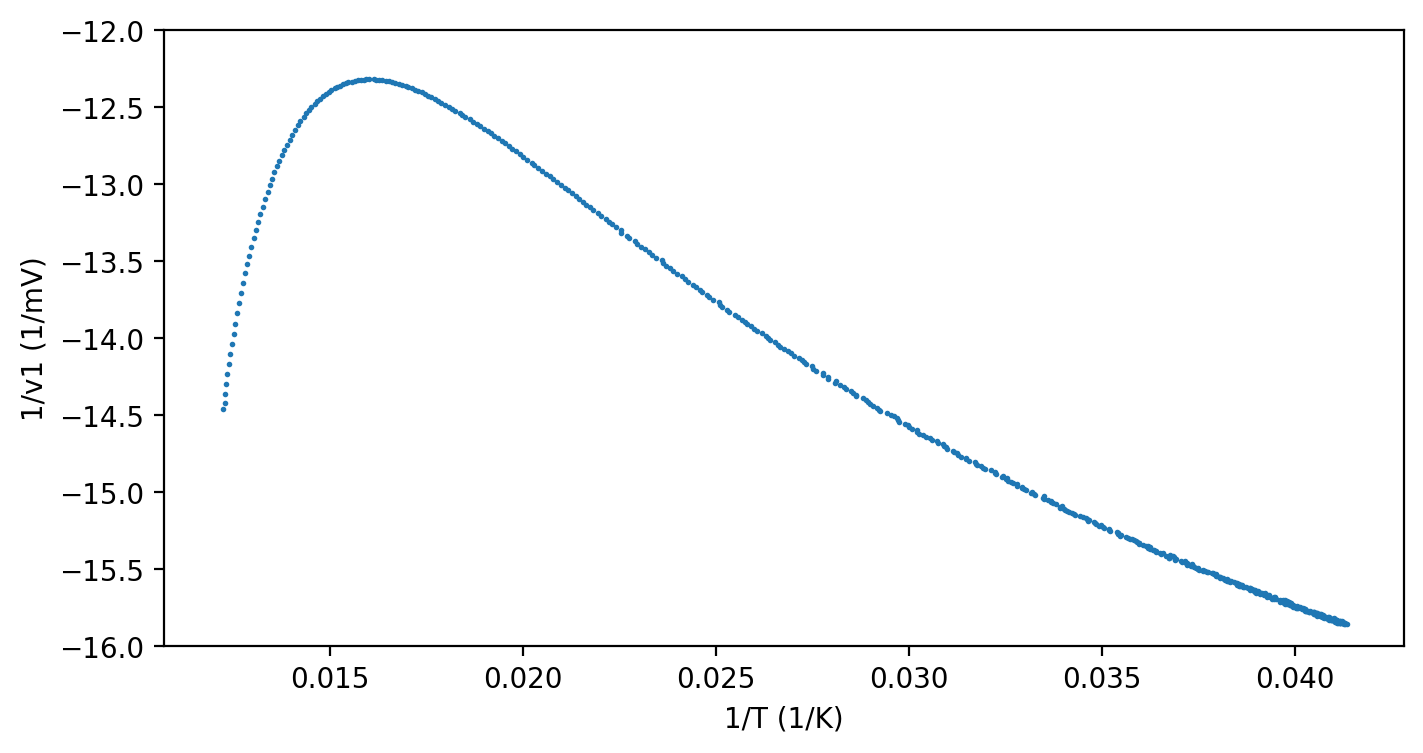

In [54]:
plt.figure(figsize=(8, 4), dpi=200)
plt.scatter(1/data['T'], 1/dict['v1'], s = 1)
plt.ylim(-16, -12)
plt.xlabel('1/T (1/K)')
plt.ylabel('1/v1 (1/mV)')

TO DO: 
- actually put it in terms of the conductivity
- perform fit in linear region (i'm thinking 0.025 to 0.03 type of vibe)
- plot the residuals